# Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle

# Set Global Variables

In [ ]:
language = 'asl'
PARENT_FOLDER = '/content/drive/MyDrive/sign-language/{}/'.format(language)
DESTINATION_FOLDER = '/content/drive/MyDrive/sign-language/split/{}'.format(language)


OUTPUT_PATH = '/content/drive/MyDrive/sign-language/model/'
MODEL_PATH = os.path.join(OUTPUT_PATH, '{}_custom.keras'.format(language))
HISTORY_PATH = os.path.join(OUTPUT_PATH, '{}_custom.pkl'.format(language))


BATCH_SIZE = 32
EPOCHS = 15
TRAIN_DIR = os.path.join(DESTINATION_FOLDER, 'train')
TEST_DIR = os.path.join(DESTINATION_FOLDER, 'test')

# Data augmentation and normalization


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define image parameters
img_width, img_height = 100, 100
input_shape = (img_width, img_height, 3)


# Generate batches of augmented training and testing data


In [ ]:
# Prepare training and testing data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2124 images belonging to 36 classes.
Found 396 images belonging to 36 classes.


# Define a CNN model

In [ ]:
# Define the CNN model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(36, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 28224)            

# Training the model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True,
                                                save_weights_only=False, mode='max')

# Train the model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=[checkpoint])


Epoch 1/15
67/67 [==============================] - 974s 15s/step - loss: 2.5778 - accuracy: 0.2947 - val_loss: 1.1271 - val_accuracy: 0.6364
Epoch 2/15
67/67 [==============================] - 47s 692ms/step - loss: 1.0968 - accuracy: 0.6577 - val_loss: 0.5352 - val_accuracy: 0.7980
Epoch 3/15
67/67 [==============================] - 49s 730ms/step - loss: 0.6674 - accuracy: 0.7787 - val_loss: 0.4861 - val_accuracy: 0.8359
Epoch 4/15
67/67 [==============================] - 49s 725ms/step - loss: 0.5148 - accuracy: 0.8178 - val_loss: 0.3640 - val_accuracy: 0.8737
Epoch 5/15
67/67 [==============================] - 46s 687ms/step - loss: 0.4039 - accuracy: 0.8653 - val_loss: 0.3095 - val_accuracy: 0.8965
Epoch 6/15
67/67 [==============================] - 46s 685ms/step - loss: 0.3051 - accuracy: 0.8992 - val_loss: 0.1955 - val_accuracy: 0.9242
Epoch 7/15
67/67 [==============================] - 49s 724ms/step - loss: 0.2691 - accuracy: 0.9040 - val_loss: 0.1351 - val_accuracy: 0.9520


In [ ]:
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
# Load the best model
best_model = tf.keras.models.load_model(MODEL_PATH)

# Evaluate the model
loss, accuracy = best_model.evaluate(test_generator)
print(f'Testing Accuracy: {accuracy}')

13/13 [==============================] - 4s 244ms/step - loss: 0.0869 - accuracy: 0.9646
Testing Accuracy: 0.9646464586257935


# Results of training phase

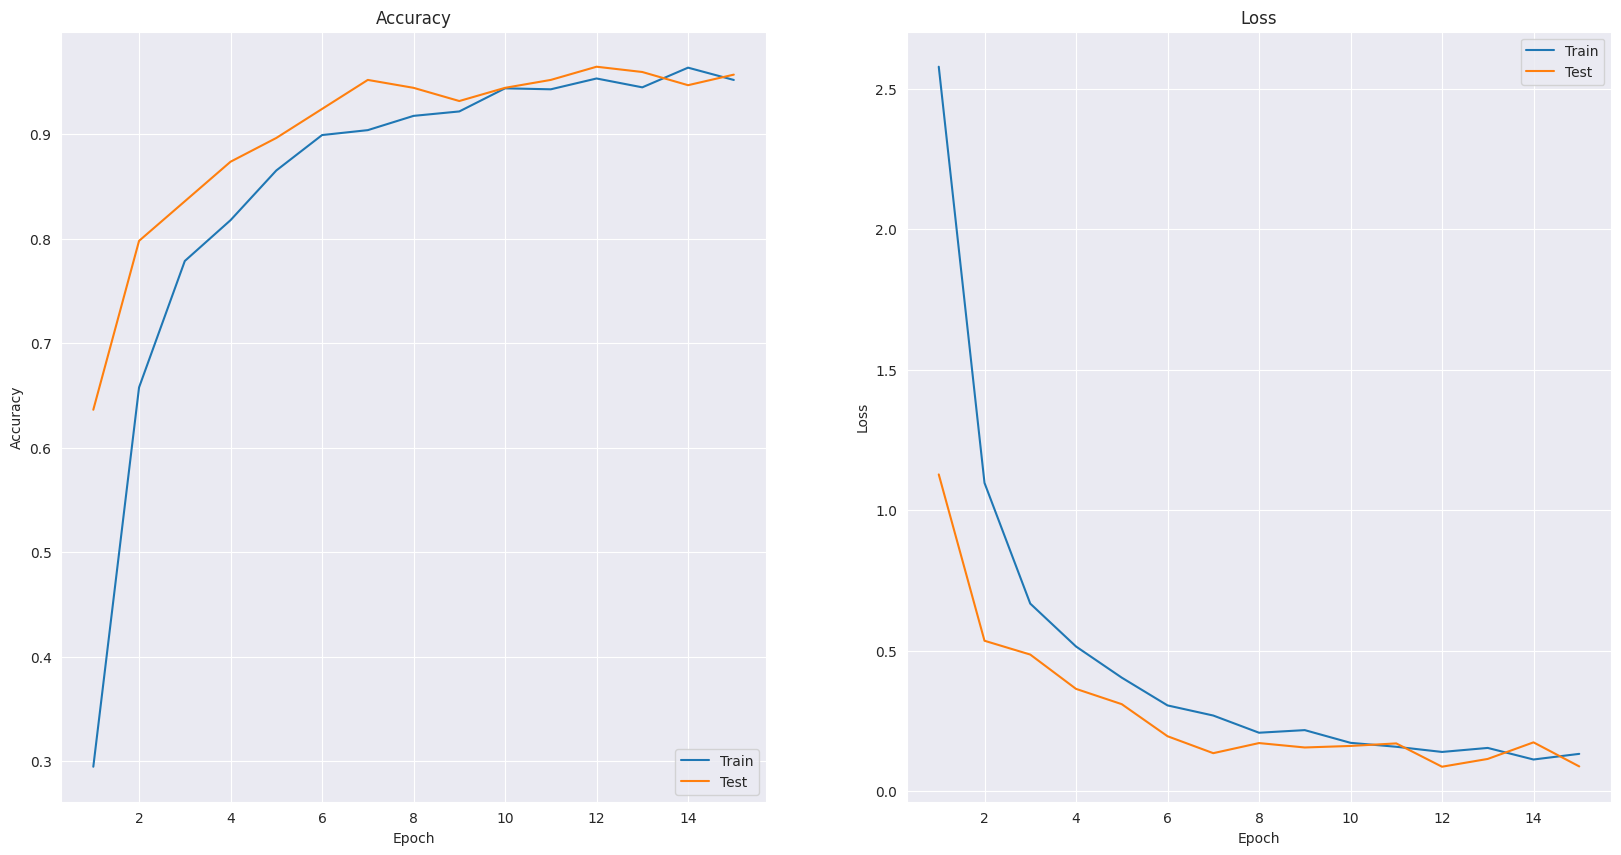

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize=(20, 10))

x = [i+1 for i in range(EPOCHS)]

plt.subplot(1, 2, 1)
sns.lineplot(x=x, y=history.history['accuracy'], label='Train')
sns.lineplot(x=x, y=history.history['val_accuracy'], label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
sns.lineplot(x=x, y=history.history['loss'], label='Train')
sns.lineplot(x=x, y=history.history['val_loss'], label='Test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.savefig(os.path.join(OUTPUT_PATH, '{}_custom.png'.format(language)))
plt.show()

# Confusion Matrix

13/13 [==============================] - 2s 119ms/step


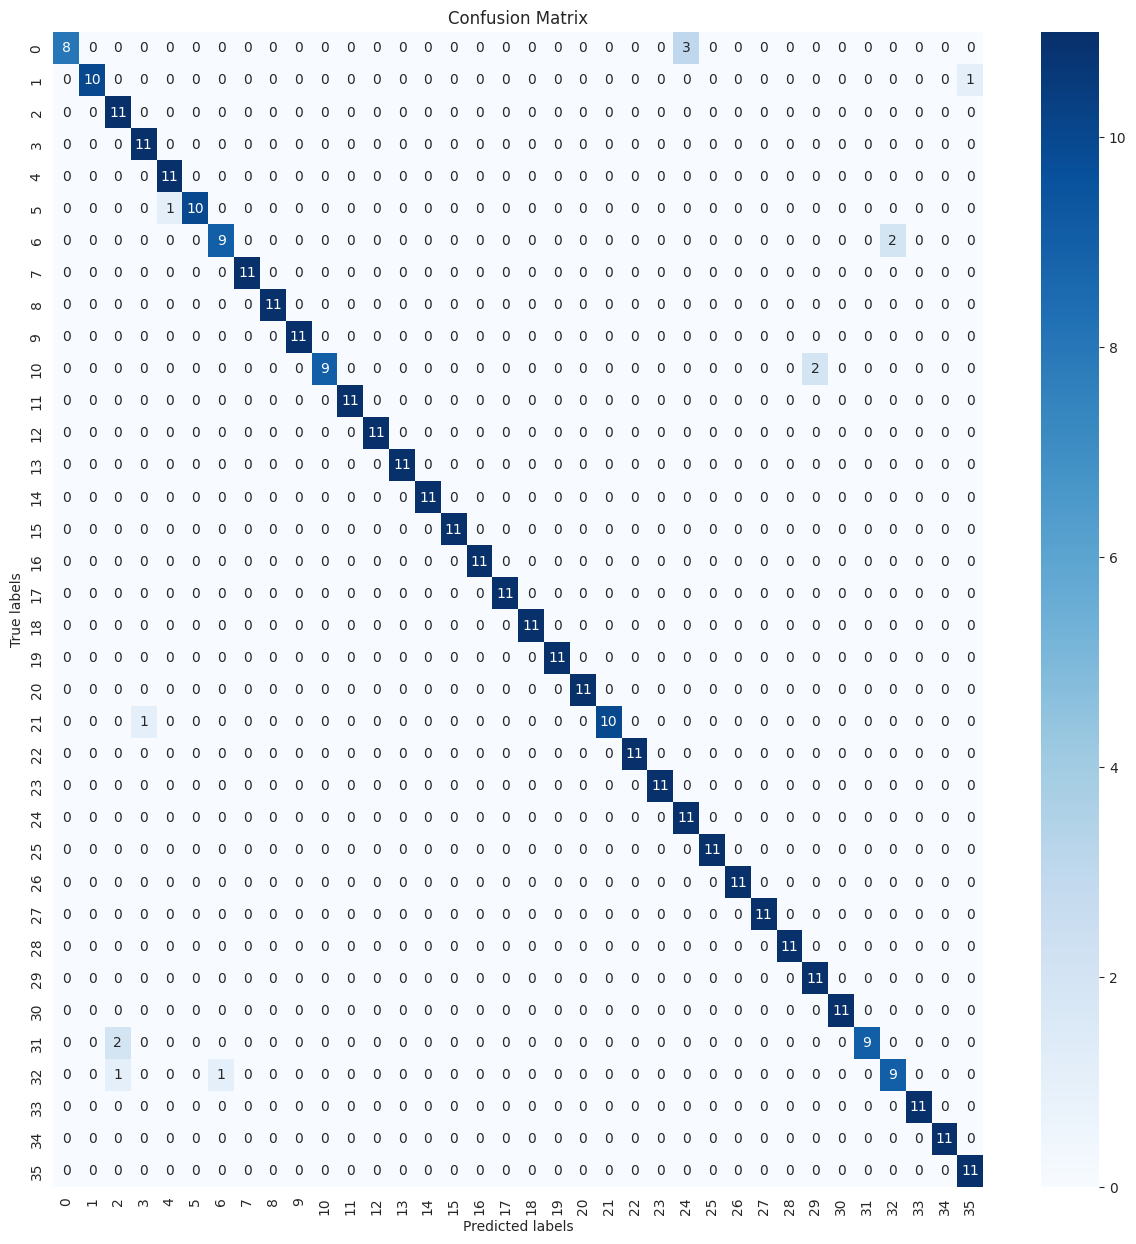

In [ ]:

test_images = []
test_labels = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    test_images.extend(batch[0])
    test_labels.extend(np.argmax(batch[1], axis=1))

test_images = np.array(test_images)
test_labels = np.array(test_labels)
predictions = np.argmax(best_model.predict(test_images), axis=1)

cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(15, 15))
labels = os.listdir(TEST_DIR)
labels.sort()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_PATH, '{}_custom_conf.png'.format(language)))
plt.show()